In [ ]:
#Étape 1 : Récupération des données via API 

In [126]:
import numpy as np
import pandas as pd

In [3]:
import requests as r

In [4]:
df_user = pd.DataFrame(r.get("https://dummyjson.com/users?limit=400").json()['users'])
df_cart = pd.DataFrame(r.get("https://dummyjson.com/carts?limit=400").json()['carts'])
df_product = pd.DataFrame(r.get("https://dummyjson.com/products?limit=400").json()['products'])

In [7]:
df_product.shape

(194, 22)

In [13]:
df_product.columns

Index(['id', 'title', 'description', 'category', 'price', 'discountPercentage',
       'rating', 'stock', 'tags', 'brand', 'sku', 'weight', 'dimensions',
       'warrantyInformation', 'shippingInformation', 'availabilityStatus',
       'reviews', 'returnPolicy', 'minimumOrderQuantity', 'meta', 'images',
       'thumbnail'],
      dtype='str')

In [ ]:
#nettoyer : supprimer les colonnes inutiles  

In [17]:
#we can try to clean the data
#pour users
df_user = df_user.drop(columns =['image', 'bloodGroup',
       'height', 'weight', 'eyeColor', 'hair', 'ip', 'phone', 'macAddress',
       'university', 'bank', 'company', 'ein', 'ssn', 'userAgent', 'crypto',
       'role','password', 'username','maidenName'],  errors = 'ignore')

#pour cart
df_cart = df_cart.drop(columns=['total', 'discountedTotal','totalProducts',
       'totalQuantity','id'],  errors = 'ignore')

#pour product
df_product = df_product.drop(columns =['discountPercentage','description',
       'rating', 'stock', 'tags', 'brand', 'sku', 'weight', 'dimensions',
       'warrantyInformation', 'shippingInformation', 'availabilityStatus',
       'reviews', 'returnPolicy', 'minimumOrderQuantity', 'meta', 'images',
       'thumbnail'] , errors = 'ignore')

In [86]:
df_product.head()

,id,title,category,price
0,1,Essence Mascara Lash Princess,beauty,9.99
1,2,Eyeshadow Palette with Mirror,beauty,19.99
2,3,Powder Canister,beauty,14.99
3,4,Red Lipstick,beauty,12.99
4,5,Red Nail Polish,beauty,8.99


In [65]:
import ast
import json

In [70]:

# Fonction sûre pour parser le JSON
def safe_json_parse(x):
    if not isinstance(x, str) or not x.strip():  # vide ou pas string
        return {}
    try:
        return json.loads(x)
    except (json.JSONDecodeError, TypeError):
        return {}  # retourne dict vide en cas d'erreur

# Appliquer la fonction sûre
df_user['address_parsed'] = df_user['address'].apply(safe_json_parse)

# Maintenant normaliser sans risque
df_address = pd.json_normalize(df_user['address_parsed'])

# Fusionner avec le reste
df_user_clean = pd.concat(
    [df_user.drop(columns=['address', 'address_parsed']), df_address],
    axis=1
)
# Garder uniquement la première occurrence de chaque nom de colonne
df_user_clean = df_user_clean.loc[:, ~df_user_clean.columns.duplicated()]

# Afficher pour vérifier
print(df_user_clean[['id', 'firstName', 'lastName', 'state', 'city']].head(10))


   id  firstName  lastName         state          city
0   1      Emily   Johnson   Mississippi       Phoenix
1   2    Michael  Williams       Alabama       Houston
2   3     Sophia     Brown       Alabama    Washington
3   4      James     Davis  Pennsylvania       Seattle
4   5       Emma    Miller      Colorado  Jacksonville
5   6     Olivia    Wilson     Tennessee    Fort Worth
6   7  Alexander     Jones      Delaware  Indianapolis
7   8        Ava    Taylor  Rhode Island    Fort Worth
8   9      Ethan  Martinez     Louisiana   San Antonio
9  10   Isabella  Anderson          Utah      New York


In [79]:
df_user_clean.columns

Index(['id', 'firstName', 'lastName', 'age', 'gender', 'email', 'birthDate',
       'city', 'state', 'stateCode', 'postalCode', 'country',
       'coordinates.lat', 'coordinates.lng'],
      dtype='str')

In [83]:
df_user_clean = df_user_clean.drop(columns = ['stateCode', 'postalCode', 'country',
      'coordinates.lat', 'coordinates.lng'])

In [82]:
df_user_clean.shape

(208, 9)

In [28]:
#on voit que dans le panier cart la colonne doit exploser pour pouvoir etre utiliser
#premiere on explode cette colonnne pour qu'il devient des lignes
df_cart_exp = df_cart.explode(['products'])

#on va normaliser la colonne
df_cart_info = pd.json_normalize(df_cart_exp['products'])

#on reinitialise les index
df_cart_exp = df_cart_exp.reset_index(drop=True)
df_cart_info = df_cart_info.reset_index(drop=True)

#on concatene tout en supprimant l'ancienne colonne
df_cart_final = pd.concat([df_cart_exp.drop(columns = ['products']), df_cart_info], axis = 1)
df_cart_final.columns

Index(['userId', 'id', 'title', 'price', 'quantity', 'total',
       'discountPercentage', 'discountedTotal', 'thumbnail'],
      dtype='str')

In [69]:
df_cart_final = df_cart_final.drop(columns = ['total',
       'discountPercentage', 'discountedTotal', 'thumbnail'], errors = 'ignore')
df_cart_final.head()

,userId,id,title,price,quantity
0,33,168,Charger SXT RWD,32999.99,3
1,33,78,Apple MacBook Pro 14 Inch Space Grey,1999.99,2
2,33,183,Green Oval Earring,24.99,5
3,33,100,Apple Airpods,129.99,5
4,142,144,Cricket Helmet,44.99,4


In [84]:
#calculer le montant

In [85]:
df_cart_final['amount'] = df_cart_final['price'] * df_cart_final['quantity'] 
df_cart_final.head()

,userId,id,title,price,quantity,amount
0,33,168,Charger SXT RWD,32999.99,3,98999.97
1,33,78,Apple MacBook Pro 14 Inch Space Grey,1999.99,2,3999.98
2,33,183,Green Oval Earring,24.99,5,124.95
3,33,100,Apple Airpods,129.99,5,649.95
4,142,144,Cricket Helmet,44.99,4,179.96


In [71]:
#verifier les NaN

In [77]:
df_user.isna().sum()

id                 0
firstName          0
lastName           0
age                0
gender             0
                  ..
postalCode         0
country            0
coordinates.lat    0
coordinates.lng    0
address_parsed     0
Length: 233, dtype: int64

In [ ]:
#Étape 2 : Nettoyage & Feature Engineering (NumPy + Pandas) 

In [88]:
#rename id(user) pour userId pour ne pas creer de confusion
df_user_clean = df_user_clean.rename(columns = {'id':'userId'})
df_user_clean.columns

Index(['userId', 'firstName', 'lastName', 'age', 'gender', 'email',
       'birthDate', 'city', 'state'],
      dtype='str')

In [92]:
#merge cart avec user via userId
df_final = pd.merge(df_cart_final, df_user_clean ,on='userId', how='left')

In [94]:
df_final = df_final.drop(columns =['id'],errors='ignore')

In [95]:
df_final.columns

Index(['userId', 'title', 'price', 'quantity', 'amount', 'firstName',
       'lastName', 'age', 'gender', 'email', 'birthDate', 'city', 'state'],
      dtype='str')

In [ ]:
#sauvegarder le dataframe final en csv et verifier les valeurs aberantes

In [127]:
# Générer des dates aléatoires entre 2023 et 2025 pour chaque ligne de df_final
start_date = np.datetime64('2023-01-01')
end_date = np.datetime64('2025-01-01')
n_rows = len(df_final)

# On crée une nouvelle colonne 'order_date'
df_final['date'] = start_date + np.random.choice(np.arange(0, (end_date - start_date).astype(int)), n_rows)


In [130]:
df_final = df_final.drop(columns =['birthDate'], errors = 'ignore')

In [131]:
df_final.columns

Index(['userId', 'title', 'price', 'quantity', 'amount', 'firstName',
       'lastName', 'age', 'gender', 'email', 'city', 'state', 'date'],
      dtype='str')

In [132]:
df_final['amount'] = df_final['amount'].round(2)
df_final['price'] = df_final['price'].round(2)

df_final.to_csv("data_clean.csv",index=False)

In [133]:
df_final.isna().sum()

userId       0
title        0
price        0
quantity     0
amount       0
firstName    0
lastName     0
age          0
gender       0
email        0
city         0
state        0
date         0
dtype: int64

In [134]:
df_final.columns.to_list()

['userId',
 'title',
 'price',
 'quantity',
 'amount',
 'firstName',
 'lastName',
 'age',
 'gender',
 'email',
 'city',
 'state',
 'date']

In [108]:
#aggregation avec userId pour df_client

In [135]:
#couvertir la date en datetime
df_final['date'] = pd.to_datetime(df_final['date'])

df_client = df_final.groupby('userId').agg(
    total_spent = ('amount', 'sum'),
    nb_purchase = ('userId', 'count'),
    last_purchase = ('date', 'max'),
    first_purchase = ('date', 'min')
).reset_index()
#df_final.columns = df_final.columns.str.strip()
df_client.columns

Index(['userId', 'total_spent', 'nb_purchase', 'last_purchase',
       'first_purchase'],
      dtype='str')

In [114]:
#calculer la avg_basket,recence,teneure

In [136]:
df_client['avg_basket'] = df_client['total_spent'] / df_client['nb_purchase']

In [138]:
#on fixe la date du jour pour calculer la recence 
today = df_client['last_purchase'].max() + pd.Timedelta(days=1)

#recence
df_client['recency_day'] = (today -df_client['last_purchase']).dt.days

#teneure
df_client['teneure_day'] = (today -df_client['first_purchase']).dt.days
df_client.head()

,userId,total_spent,nb_purchase,last_purchase,first_purchase,avg_basket,recency_day,teneure_day
0,6,1749.90,3,2024-03-11,2023-01-10,583.30,296,722
1,11,11741.31,5,2024-12-31,2023-01-11,2348.26,1,721
2,15,3359.79,6,2024-02-25,2023-01-22,559.97,311,710
3,20,460.87,4,2024-08-27,2023-04-30,115.22,127,612
4,23,16143.72,9,2024-11-17,2023-06-04,1793.75,45,577


In [139]:
#Étape 3 : Analyse Exploratoire (EDA + NumPy 2D)

In [142]:
df_client[['total_spent', 'nb_purchase', 'recency_day']].describe()

,total_spent,nb_purchase,recency_day
count,45.00,45.00,45.00
mean,22317.06,4.40,163.36
std,51319.60,1.98,133.24
min,36.28,2.00,1.00
25%,456.83,3.00,50.00
50%,1749.90,4.00,135.00
75%,12059.93,6.00,271.00
max,274072.67,10.00,532.00


In [143]:
#Matrice corrélation avec np.corrcoef sur .values  
matrix = df_client[['total_spent', 'nb_purchase', 'recency_day']].values

corr = np.corrcoef(matrix.T) #T la transpose
print("la matrice de correlation est \n", corr)

la matrice de correlation est 
 [[ 1.          0.52980224 -0.19811406]
 [ 0.52980224  1.         -0.36869075]
 [-0.19811406 -0.36869075  1.        ]]


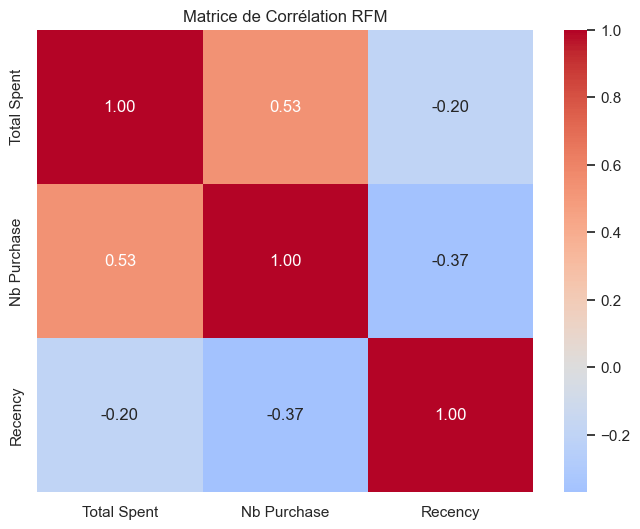

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Configurer le style et la taille
plt.figure(figsize=(8, 6))
sns.set_theme(style="white")

# 2. Créer la heatmap
# annot=True affiche les chiffres dans les cases
# cmap='coolwarm' met du bleu pour le négatif et du rouge pour le positif
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            xticklabels=['Total Spent', 'Nb Purchase', 'Recency'],
            yticklabels=['Total Spent', 'Nb Purchase', 'Recency'])

# 3. Ajouter un titre
plt.title("Matrice de Corrélation RFM")
plt.show()

In [149]:
#Boxplot total_spent par catégorie user (gender, city)  

In [145]:
# On fusionne pour récupérer le genre et la ville
df_plot = df_client.merge(df_final[['userId', 'gender', 'city']].drop_duplicates(), on='userId')

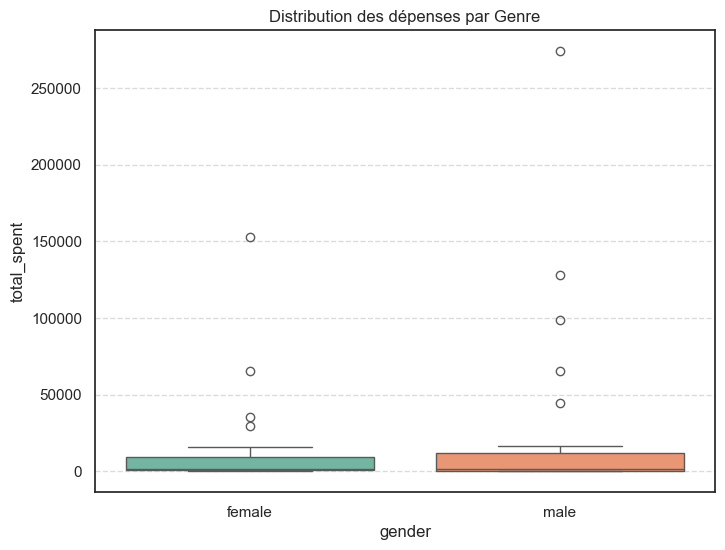

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_plot, x='gender', y='total_spent', palette='Set2')
plt.title('Distribution des dépenses par Genre')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

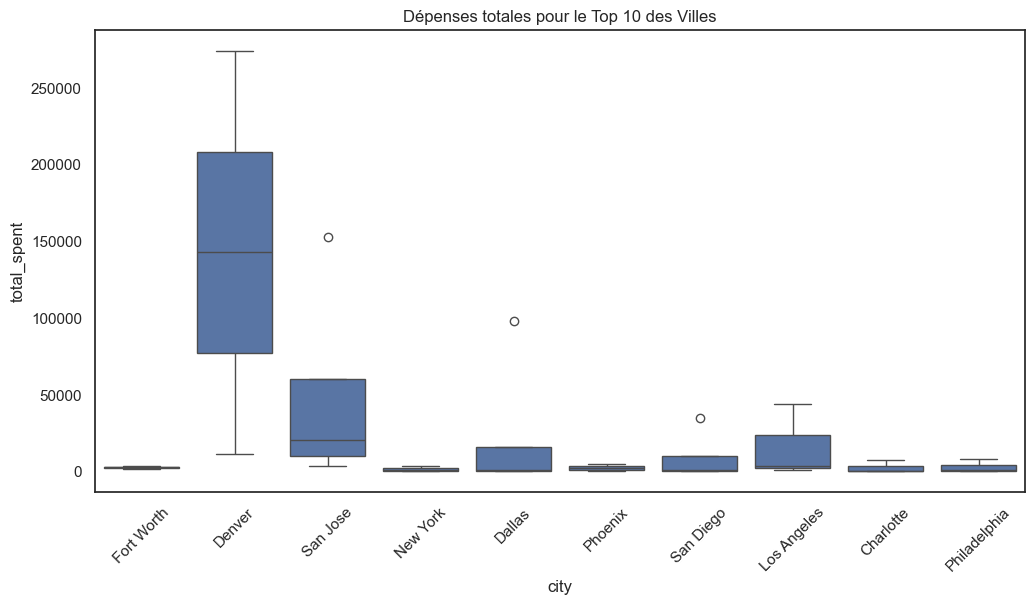

In [153]:
# Top 10 des villes avec le plus de clients
top_cities = df_plot['city'].value_counts().nlargest(10).index
df_top_cities = df_plot[df_plot['city'].isin(top_cities)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_cities, x='city', y='total_spent')
plt.xticks(rotation=45) # Incliner les noms des villes
plt.title('Dépenses totales pour le Top 10 des Villes')
plt.show()

In [ ]:
#Top 10 clients total_spent (np.argsort)  

In [154]:
#on recupere les indices pour total_spent
indice = np.argsort(df_client['total_spent'].values)

#on inverse l'ordre pour mettre le plus gros en haut
indice_top_10 = indice[-10:][::-1]

#on creer le dataframe
df_top_10 = df_client.iloc[indice_top_10]

#affichage
print("=== top des 10 clients (total sepnt)====\n")
display(df_top_10[['userId','total_spent','nb_purchase']])

=== top des 10 clients (total sepnt)====



,userId,total_spent,nb_purchase
5,33,274072.67,10
16,86,152668.66,9
36,177,128249.07,4
39,187,98499.82,6
41,194,65529.87,4
32,164,65519.87,4
15,81,44376.84,6
29,150,35199.86,4
31,160,29499.92,2
21,108,16775.87,5


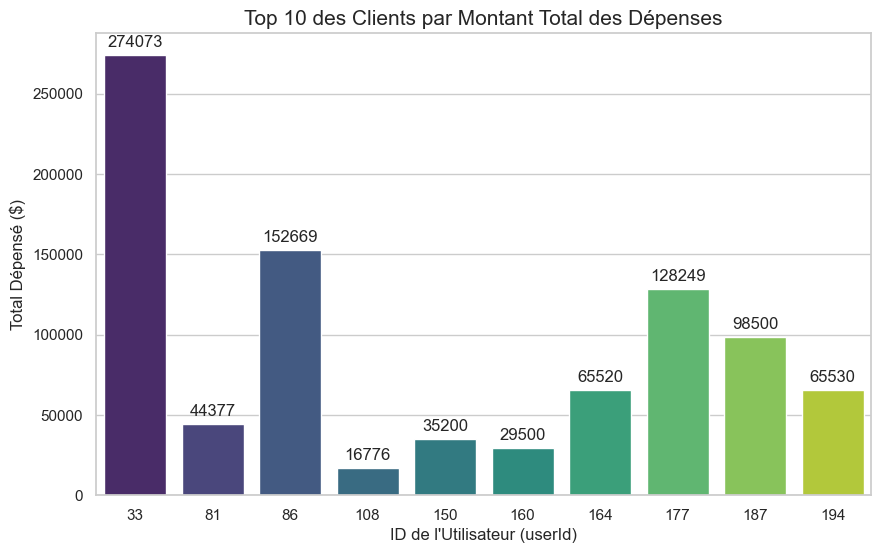

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style et la taille
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

# Créer le graphique à barres
# On trie par total_spent pour avoir un effet d'escalier visuel
plot = sns.barplot(
    data=df_top_10.sort_values('total_spent', ascending=False), 
    x='userId', 
    y='total_spent', 
    palette='viridis' # Un dégradé de couleur élégant
)

# Ajouter les étiquettes de texte au-dessus de chaque barre pour plus de clarté
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

# Titres et labels
plt.title('Top 10 des Clients par Montant Total des Dépenses', fontsize=15)
plt.xlabel('ID de l\'Utilisateur (userId)', fontsize=12)
plt.ylabel('Total Dépensé ($)', fontsize=12)

plt.show()

In [155]:
#Pourcentage clients inactifs (>180 jours recency)

In [161]:
df_client['status_client'] = np.where(
    df_client['recency_day'] > 180, 'inactif', 'actif')
nb_client = len(df_client)
nb_inactif = len(df_client['status_client'] == 'inactif')
pct_inactif = (nb_inactif / nb_client) * 100

#affichage
print(f"nombre total des clients :{nb_client}")
print(f"le nombre des clients inactifs :{nb_inactif}")
print(f"le pourcentage des clients inactifs :{pct_inactif:.2f}%")

nombre total des clients :45
le nombre des clients inactifs :45
le pourcentage des clients inactifs :100.00%


In [163]:
#Étape 4 : Création d’un score client simple (RFM light)

In [178]:
#calculer R_score
df_client['R_score'] = pd.qcut(
    df_client['recency_day'],
    q = 5,
    labels = [5, 4, 3, 2, 1]
).astype(int)

#calcule F_score
df_client['F_score'] = pd.qcut(
    df_client['nb_purchase'].rank(method='first'),
    q = 5,
    labels = [1, 2, 3, 4, 5]
).astype(int)

#calculer M_score
df_client['M_score'] = pd.qcut(
    df_client['total_spent'],
    q = 5,
    labels = [1, 2, 3, 4, 5]
).astype(int)

#calculons le RFM
df_client['RFM'] = df_client['R_score'] + df_client['F_score'] + df_client['M_score']
display(df_client[['userId','recency_day','nb_purchase','total_spent','RFM']].head())

,userId,recency_day,nb_purchase,total_spent,RFM
0,6,296,3,1749.90,6
1,11,1,5,11741.31,13
2,15,311,6,3359.79,8
3,20,127,4,460.87,7
4,23,45,9,16143.72,13


In [171]:
#creer les segments

In [181]:
df_client['RFM'] = df_client['R_score'] + df_client['F_score'] + df_client['M_score']
limites = [0, 5, 8, 11, 15]
order_segment = ['Perdus','À risque','Loyaux','Champions']

df_client['segment'] = pd.cut(
    df_client['RFM'],
    bins = limites,
    labels = order_segment
)

#print("=====les differents segments sont=======")
#display(df_client['segment'].value_counts())
# Vérifie les types (doit être int)
print("Type de RFM_score :", df_client['RFM'].dtype)  # int64 ou int32

# Vérifie la répartition (plus lisible)
print("\nRépartition des segments RFM :")
print(df_client['segment'].value_counts().sort_index())

# Pourcentage
print("\nPourcentages :")
print(df_client['segment'].value_counts(normalize=True).mul(100).round(1).astype(str) + ' %')

Type de RFM_score : int64

Répartition des segments RFM :
segment
Perdus        7
À risque     11
Loyaux       18
Champions     9
Name: count, dtype: int64

Pourcentages :
segment
Loyaux       40.0 %
À risque     24.4 %
Champions    20.0 %
Perdus       15.6 %
Name: proportion, dtype: str


In [191]:
df_client

,userId,total_spent,nb_purchase,last_purchase,first_purchase,avg_basket,recency_day,teneure_day,status_client,R_score,F_score,M_score,RFM,segment
0,6,1749.90,3,2024-03-11,2023-01-10,583.30,296,722,inactif,1,2,3,6,À risque
1,11,11741.31,5,2024-12-31,2023-01-11,2348.26,1,721,actif,5,4,4,13,Champions
2,15,3359.79,6,2024-02-25,2023-01-22,559.97,311,710,inactif,1,4,3,8,À risque
3,20,460.87,4,2024-08-27,2023-04-30,115.22,127,612,actif,3,2,2,7,À risque
4,23,16143.72,9,2024-11-17,2023-06-04,1793.75,45,577,actif,4,5,4,13,Champions
5,33,274072.67,10,2024-12-19,2023-09-22,27407.27,13,467,actif,5,5,5,15,Champions
6,35,179.96,2,2024-10-13,2024-07-06,89.98,80,179,actif,4,1,1,6,À risque
7,41,793.07,5,2024-03-22,2023-02-07,158.61,285,694,inactif,1,4,2,7,À risque
8,42,251.96,2,2023-09-17,2023-07-19,125.98,472,532,inactif,1,1,1,3,Perdus
9,50,260.89,3,2023-11-25,2023-08-04,86.96,403,516,inactif,1,2,1,4,Perdus


In [192]:
df_client.to_csv("client_complet.csv", index=False)

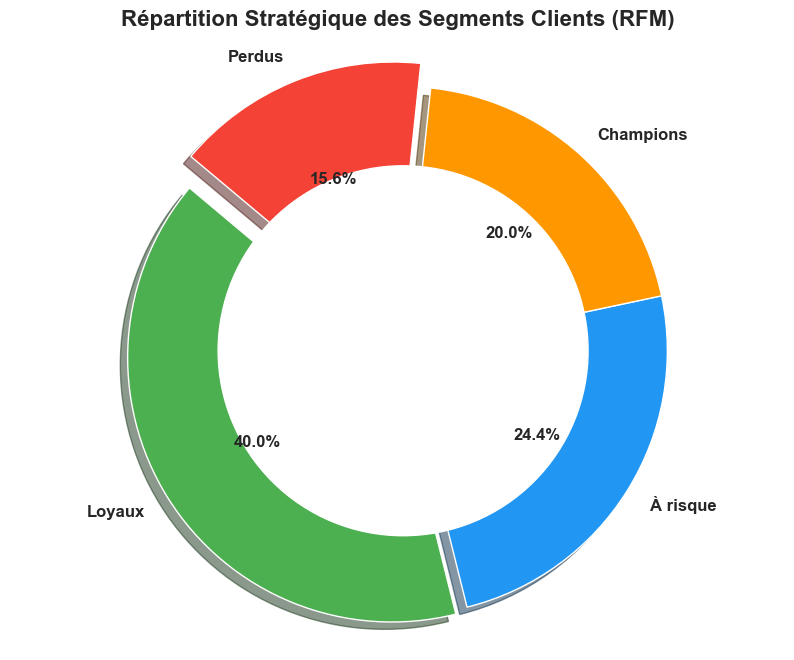

In [182]:
import matplotlib.pyplot as plt

# 1. Récupérer les données de ton dernier calcul
segment_counts = df_client['segment'].value_counts()

# 2. Configurer les couleurs (harmonieuses avec tes segments)
colors = ['#4CAF50', '#2196F3', '#FF9800', '#F44336'] # Vert, Bleu, Orange, Rouge
explode = (0.05, 0, 0, 0.1)  # On "sort" un peu les Champions et les Perdus pour l'effet visuel

# 3. Création du graphique
plt.figure(figsize=(10, 8))
plt.pie(
    segment_counts, 
    labels=segment_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=colors, 
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Ajouter un cercle au milieu pour en faire un "Donut Chart" (plus moderne)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Répartition Stratégique des Segments Clients (RFM)', fontsize=16, fontweight='bold')
plt.axis('equal')  # Assure que le pie chart est bien rond
plt.show()

In [ ]:
#CA total par segment (barplot)

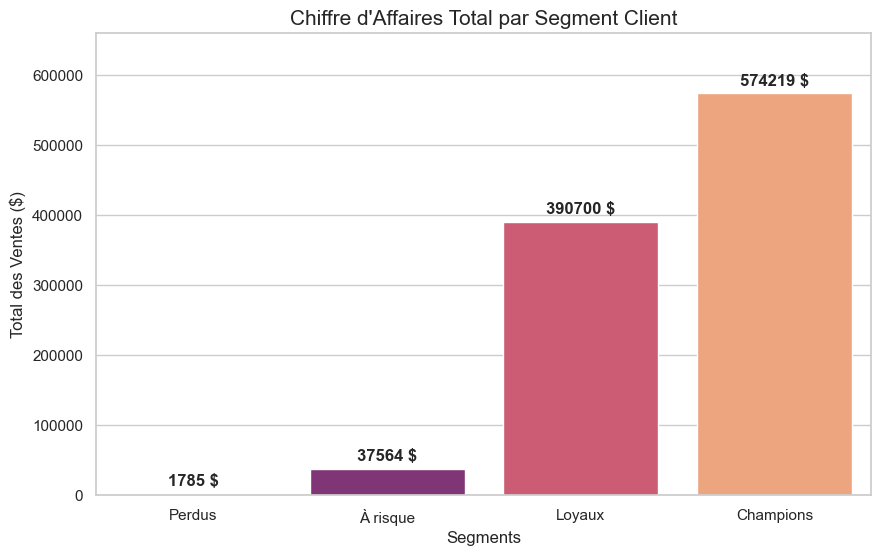

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns # ou import seaborn as sns selon ton import habituel

# 1. Calculer le CA total par segment
ca_par_segment = df_client.groupby('segment')['total_spent'].sum().sort_values(ascending=False).reset_index()

# 2. Création du graphique
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

plot = sns.barplot(
    data=ca_par_segment, 
    x='segment', 
    y='total_spent', 
    palette='magma' # Dégradé de couleurs pro
)

# 3. Ajouter les labels de prix sur les barres
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f') + ' $', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontweight='bold')

plt.title('Chiffre d\'Affaires Total par Segment Client', fontsize=15)
plt.xlabel('Segments', fontsize=12)
plt.ylabel('Total des Ventes ($)', fontsize=12)
plt.ylim(0, ca_par_segment['total_spent'].max() * 1.15) # Donne de l'espace pour les labels

plt.show()

In [188]:
df_final.columns

Index(['userId', 'title', 'price', 'quantity', 'amount', 'firstName',
       'lastName', 'age', 'gender', 'email', 'city', 'state', 'date'],
      dtype='str')

In [189]:
# Filtrer pour n'avoir que les champions et trier par le plus gros montant
df_top_champions = df_client[df_client['segment'] == 'Champions'].sort_values(by='total_spent', ascending=False).head(10)

# Afficher toutes les colonnes pour ces 10 clients
print("=== Détails complets du Top 10 Champions ===")
display(df_top_champions)

=== Détails complets du Top 10 Champions ===


,userId,total_spent,nb_purchase,last_purchase,first_purchase,avg_basket,recency_day,teneure_day,status_client,R_score,F_score,M_score,RFM,segment
5,33,274072.67,10,2024-12-19,2023-09-22,27407.27,13,467,actif,5,5,5,15,Champions
16,86,152668.66,9,2024-09-20,2023-03-05,16963.18,103,668,actif,4,5,5,14,Champions
39,187,98499.82,6,2024-12-12,2023-03-13,16416.64,20,660,actif,5,5,5,15,Champions
4,23,16143.72,9,2024-11-17,2023-06-04,1793.75,45,577,actif,4,5,4,13,Champions
1,11,11741.31,5,2024-12-31,2023-01-11,2348.26,1,721,actif,5,4,4,13,Champions
28,147,7967.71,7,2024-12-17,2023-02-06,1138.24,15,695,actif,5,5,4,14,Champions
23,134,7431.30,6,2024-12-28,2023-02-06,1238.55,4,695,actif,5,5,4,14,Champions
27,143,4749.87,4,2024-11-29,2023-06-14,1187.47,33,567,actif,5,3,4,12,Champions
38,184,944.00,6,2024-12-27,2023-05-28,157.33,5,584,actif,5,5,3,13,Champions


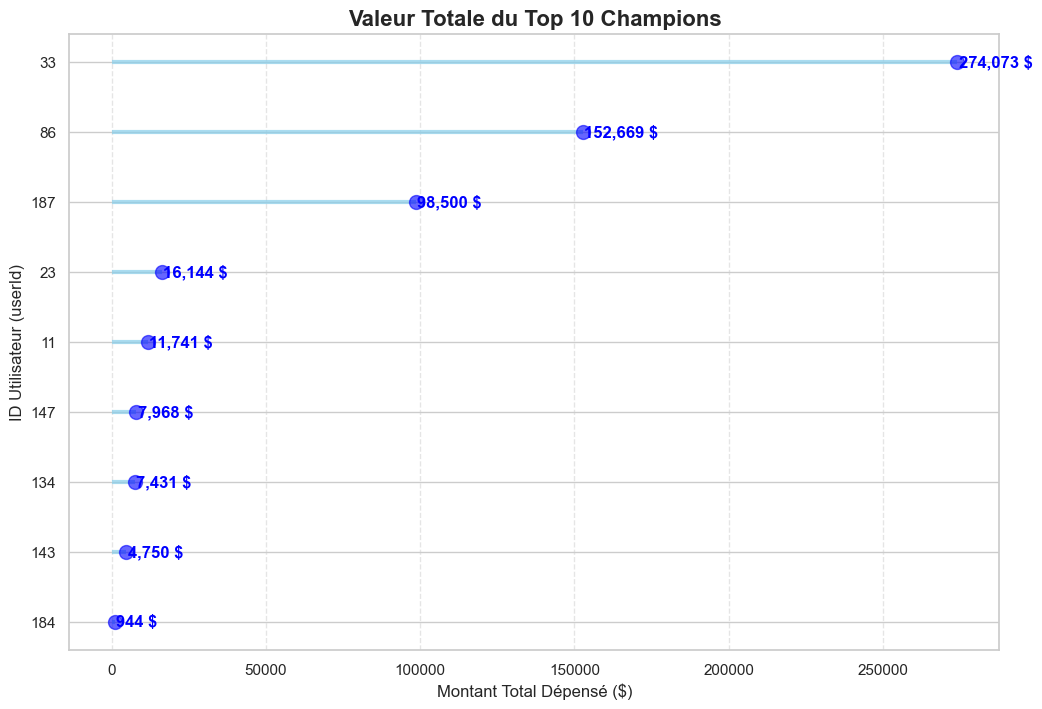

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns

# Préparation des données
df_plot = df_top_champions.sort_values('total_spent')

plt.figure(figsize=(12, 8))
plt.hlines(y=range(len(df_plot)), xmin=0, xmax=df_plot['total_spent'], color='skyblue', alpha=0.7, linewidth=3)
plt.plot(df_plot['total_spent'], range(len(df_plot)), "o", markersize=10, color='blue', alpha=0.6)

# Ajouter les noms ou ID sur l'axe Y
plt.yticks(range(len(df_plot)), df_plot['userId'])

# Ajouter les montants exacts au bout des lignes
for i, v in enumerate(df_plot['total_spent']):
    plt.text(v + 500, i, f"{v:,.0f} $", color='blue', va='center', fontweight='bold')

plt.title('Valeur Totale du Top 10 Champions', fontsize=16, fontweight='bold')
plt.xlabel('Montant Total Dépensé ($)', fontsize=12)
plt.ylabel('ID Utilisateur (userId)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()